# Building intelligent bots. Retrieval-based chatbots

In this section we build a retrieval-based chatbot with Rasa. Before we go to this point, we go through a few NLP methods and word vectorization.


## NLP methods for NLU

Let's take one of President Trump's speech and divide into words.

In [1]:
import spacy

file = open("trump.txt", "r",encoding='utf-8') 
trump = file.read() 

nlp = spacy.load("en")
doc = nlp(trump)

for span in doc.sents:
    print("> ", span)

>  Thank you, everybody.
>  Thank you.
>  Thank you very much.
>  Thank you, Matt, for that great introduction.
>  And thank you for this big crowd.
>  This is incredible.
>  Really incredible.
>  We have all come a long way together.
>  We have come a long way together.

>  I’m thrilled to be back at CPAC, with so many of my wonderful friends and amazing supporters and proud conservatives.
>  Remember when I first started running?
>  Because I wasn’t a politician, fortunately, but do you remember I started running and
>  people said, are you sure he’s a conservative?
>  I think I proved I’m a conservative.

>  For more than four decades, this event has served as a forum for our nation’s top leaders, activists, writers, and thinkers.

>  Year after year, leaders have stood on this stage to discuss what we can do together to protect our heritage, to promote our culture, and to defend our freedom.
>  CPAC has always been about big ideas, and it has also been about putting those ideas int

We have are able to divide it using SpaCy and get the part of speech of each word.

In [2]:
for span in doc.sents:
    for i in range(span.start, span.end):
        token = doc[i]
        print(i, token.text, token.pos_)    

0 Thank VERB
1 you PRON
2 , PUNCT
3 everybody NOUN
4 . PUNCT
5 Thank VERB
6 you PRON
7 . PUNCT
8 Thank VERB
9 you PRON
10 very ADV
11 much ADV
12 . PUNCT
13 Thank VERB
14 you PRON
15 , PUNCT
16 Matt PROPN
17 , PUNCT
18 for ADP
19 that DET
20 great ADJ
21 introduction NOUN
22 . PUNCT
23 And CCONJ
24 thank VERB
25 you PRON
26 for ADP
27 this DET
28 big ADJ
29 crowd NOUN
30 . PUNCT
31 This DET
32 is VERB
33 incredible ADJ
34 . PUNCT
35 Really ADV
36 incredible ADJ
37 . PUNCT
38 We PRON
39 have VERB
40 all DET
41 come VERB
42 a DET
43 long ADJ
44 way NOUN
45 together ADV
46 . PUNCT
47 We PRON
48 have VERB
49 come VERB
50 a DET
51 long ADJ
52 way NOUN
53 together ADV
54 . PUNCT
55 
 SPACE
56 I PRON
57 ’m VERB
58 thrilled ADJ
59 to PART
60 be VERB
61 back ADV
62 at ADP
63 CPAC PROPN
64 , PUNCT
65 with ADP
66 so ADV
67 many ADJ
68 of ADP
69 my ADJ
70 wonderful ADJ
71 friends NOUN
72 and CCONJ
73 amazing ADJ
74 supporters NOUN
75 and CCONJ
76 proud ADJ
77 conservatives NOUN
78 . PUNCT
79 Remem

A smaller example:

In [3]:
sample = "Broadcasting today, live from Kraków, on chatbots."

doc = nlp(sample)
for token in doc:
    print(token.text, token.pos_)

Broadcasting NOUN
today NOUN
, PUNCT
live ADV
from ADP
Kraków PROPN
, PUNCT
on ADP
chatbots NOUN
. PUNCT


### Noun chunks

This NLP method is used to get the nouns from any sentene. It's important to understand what is the sentence about.

In [4]:
doc = nlp(sample)
for nc in doc.noun_chunks:
    print(nc)

Kraków
chatbots


### Named Entity Recognition

NER is a NLP method where we get not the nouns or part of speech, but meanings of the words.

In [5]:
doc = nlp(sample)
for entity in doc.ents:
    print(entity.label_, entity.text)

DATE today
GPE Kraków


## Word vectorization

Word vectorization is a process of preparing a vector representing each word. Gensim has an implementation of Word2Vec. We use a dimension of 100 and distance between two words in a sentence to 5.

In [6]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

We can get the vocabulary as follows:

In [7]:
vocab = list(model.wv.vocab)
X = model[vocab]
print(vocab[0])

system


/usr/lib/python3/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


To train we just use the TSNE to reduce the dimensionality:

In [8]:
from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df

,x,y
system,-54.921520,-97.018845
eps,-204.911575,-63.320629
computer,71.647598,-69.492157
interface,-82.396431,29.561205
graph,37.991989,-219.500748
minors,118.630775,172.905899
time,194.162262,23.398142
response,-48.734329,179.570282
user,187.471832,-143.947357
trees,-129.380539,-212.833450


We can draw the words in a two-dimensional space:

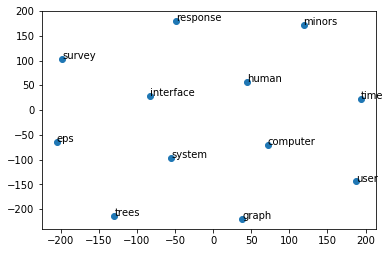

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()    

Let's take a more complex example and use a longer text.

In [13]:
!wget http://mattmahoney.net/dc/text8.zip
!unzip text8.zip

--2018-12-13 15:54:05--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: 'text8.zip'

text8.zip           100%[===================>]  29.89M   412KB/s    in 71s     

2018-12-13 15:55:16 (431 KB/s) - 'text8.zip' saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


We get the sentences from the text as follows:

In [14]:
from gensim.models import word2vec

sentences = word2vec.Text8Corpus('text8',max_sentence_length=100)

Now it's the time consuming part, load it and save the model:

In [15]:
model = Word2Vec(sentences, size=100, window=5)
model.save("word2vec.model")

We choose only 100 words. It's easier to draw 100 words from the whole dataset.

In [16]:
import random

vocab = list(model.wv.vocab)
vocab = random.sample(vocab,100)
X = model[vocab]

/usr/lib/python3/dist-packages/ipykernel/__main__.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Let's reduce the dimensionality of the new dataset.

In [17]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

Let's take a look at the chosen words.

In [18]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df

,x,y
fray,1.199213,-2.351179
migraine,-1.669107,-3.982902
sohn,-1.778359,-2.104618
fathered,0.209967,-0.057293
jann,-0.419812,-2.862719
maximally,0.303193,-3.818645
reversion,1.120170,-3.712888
timurid,-3.244972,-2.435001
valencia,-3.783758,-2.470907
imitates,0.509811,-1.583009


Draw the new dataset.

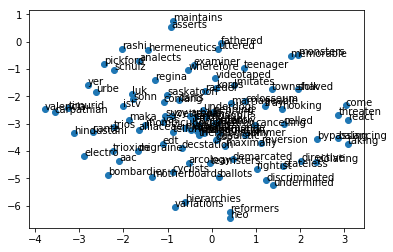

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()  

### Similarity measure through vectors

SpaCy already has words vectorized and we can simply check the similarity between two sentences.

In [20]:
import spacy

nlp = spacy.load('en')

doc1 = nlp(u"Warsaw is the largest city in Poland.")
doc2 = nlp(u"Crossaint is baked in France.")
doc3 = nlp(u"An emu is a large bird.")

for doc in [doc1, doc2, doc3]:
    for other_doc in [doc1, doc2, doc3]:
        print(doc.similarity(other_doc))

1.0
0.7187545982811518
0.6463190175867294
0.7187545982811518
1.0
0.39680156850229636
0.6463190175867294
0.39680156850229636
1.0


A nice example of word vectorization done by some researchers at Warsaw University: [Word2Vec](https://lamyiowce.github.io/word2viz/).

## Retrieval-based chatbot

In this section we use Rasa to build a very simple HR assistant bot. We can use Rasa as a server or use it directly from Python level. To start Rasa server you need to execute the following command:
```python3 -m rasa_nlu.server --path projects```.
It starts a server on default port 5000. You can test it using the request package. We should get the intent of the phrase `hi`.

In [22]:
import requests

def get_intent(sentence):
    url = "http://localhost:5000/parse"
    payload = {"q":sentence}
    response = requests.get(url,params=payload)    
    print(response.json())
    intent = response.json()['intent']
    if intent['confidence'] > 0.5: 
        return intent['name']
    return response.json()

get_intent("hi")

{'entities': [], 'model': 'fallback', 'intent': {'name': 'greet', 'confidence': 1.0}, 'project': 'default', 'text': 'hi'}


'greet'

To use Rasa from Python level you need to prepare a config file that contains the pipeline and the filename of examples used for learning.

In [23]:
config = """
{
  "pipeline": "spacy_sklearn",
  "path" : ".",
  "data" : ".anna.json"
}
"""

config_file = open("config.json", "w")
config_file.write(config)
config_file.close()

The data file contains examples that are used for training.

In [24]:
anna_common_examples = """
{
  "rasa_nlu_data": {
    "entity_synonyms": [
      {
        "value": "candidate",
        "synonyms": ["developer", "data scientist"]
      }
    ],
    "common_examples": [
      {
        "text": "hey", 
        "intent": "greet", 
        "entities": []
      }, 
      {
        "text": "howdy", 
        "intent": "greet", 
        "entities": []
      }, 
      {
        "text": "hey there",
        "intent": "greet", 
        "entities": []
      }, 
      {
        "text": "hello", 
        "intent": "greet", 
        "entities": []
      }, 
      {
        "text": "hi", 
        "intent": "greet", 
        "entities": []
      },
      {
        "text": "good morning",
        "intent": "greet",
        "entities": []
      },
      {
        "text": "good evening",
        "intent": "greet",
        "entities": []
      },
      {
        "text": "dear sir",
        "intent": "greet",
        "entities": []
      },
      {
        "text": "yes", 
        "intent": "affirm", 
        "entities": []
      }, 
      {
        "text": "yep", 
        "intent": "affirm", 
        "entities": []
      }, 
      {
        "text": "yeah", 
        "intent": "affirm", 
        "entities": []
      },
      {
        "text": "indeed",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "that's right",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "ok",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "great",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "right, thank you",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "add candidate",
        "intent": "candidate_add",
        "entities": []
      }, 
      {
        "text": "add candidate",
        "intent": "candidate_add",
        "entities": [
            {
      "start": 5,
      "end": 13,
      "value": "candidate",
      "entity": "candidate"
        }
        ]
      },         
      {
        "text": "adding candidate",
        "intent": "candidate_add",
        "entities": [
            {
              "start": 8,
              "end": 16,
              "value": "candidate",
              "entity": "candidate"
            }        
        ]
      },
      {
        "text": "please add candidate",
        "intent": "candidate_add",
        "entities": []
      },              
      {
        "text": "please add new candidate",
        "intent": "candidate_add",
        "entities": []
      },           
      {
        "text": "we have new prescreening upcoming",
        "intent": "candidate_add",
        "entities": []
      }, 
      {
        "text": "we have a new candidate for prescreening",
        "intent": "candidate_add",
        "entities": []
      },         
      {
        "text": "correct",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "great choice",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "sounds really good",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "bye", 
        "intent": "goodbye", 
        "entities": []
      }, 
      {
        "text": "goodbye", 
        "intent": "goodbye", 
        "entities": []
      }, 
      {
        "text": "good bye", 
        "intent": "goodbye", 
        "entities": []
      }, 
      {
        "text": "stop", 
        "intent": "goodbye", 
        "entities": []
      }, 
      {
        "text": "end", 
        "intent": "goodbye", 
        "entities": []
      },
      {
        "text": "farewell",
        "intent": "goodbye",
        "entities": []
      },
      {
        "text": "Bye bye",
        "intent": "goodbye",
        "entities": []
      },
      {
        "text": "have a good one",
        "intent": "goodbye",
        "entities": []
      }
    ]
  }
}
"""

training_data = open("anna.json", "w")
training_data.write(anna_common_examples)
training_data.close()

The training is straight forward.

In [26]:
from rasa_nlu.training_data import load_data
from rasa_nlu.model import Trainer, Interpreter
from rasa_nlu.components import ComponentBuilder
import rasa_nlu.config

cfg = 'config.json'
training_data = load_data('anna.json')
trainer = Trainer(rasa_nlu.config.load(cfg))
trainer.train(training_data)
model_directory = trainer.persist('.')

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


To get the intent we use the parse method.

In [29]:
from rasa_nlu.model import Metadata, Interpreter

interpreter = Interpreter.load(model_directory)

interpreter.parse(u"add developer")

{'entities': [],
 'intent': {'confidence': 0.5448019565755786, 'name': 'candidate_add'},
 'intent_ranking': [{'confidence': 0.5448019565755786,
   'name': 'candidate_add'},
  {'confidence': 0.23187658955826854, 'name': 'goodbye'},
  {'confidence': 0.12032213570828024, 'name': 'greet'},
  {'confidence': 0.1029993181578727, 'name': 'affirm'}],
 'text': 'add developer'}

## EXERCISE 2

Extend the training examples and add an intent `change_status` with entities: `passed` and `failed`.

In [ ]:
anna_common_examples = """
{
  "rasa_nlu_data": {
    "entity_synonyms": [
      {
        "value": "candidate",
        "synonyms": ["developer", "data scientist"]
      }
    ],
    "common_examples": [
      {
        "text": "hey", 
        "intent": "greet", 
        "entities": []
      }, 
      {
        "text": "howdy", 
        "intent": "greet", 
        "entities": []
      }, 
      {
        "text": "hey there",
        "intent": "greet", 
        "entities": []
      }, 
      {
        "text": "hello", 
        "intent": "greet", 
        "entities": []
      }, 
      {
        "text": "hi", 
        "intent": "greet", 
        "entities": []
      },
      {
        "text": "good morning",
        "intent": "greet",
        "entities": []
      },
      {
        "text": "good evening",
        "intent": "greet",
        "entities": []
      },
      {
        "text": "dear sir",
        "intent": "greet",
        "entities": []
      },
      {
        "text": "yes", 
        "intent": "affirm", 
        "entities": []
      }, 
      {
        "text": "yep", 
        "intent": "affirm", 
        "entities": []
      }, 
      {
        "text": "yeah", 
        "intent": "affirm", 
        "entities": []
      },
      {
        "text": "indeed",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "that's right",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "ok",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "great",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "right, thank you",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "add candidate",
        "intent": "candidate_add",
        "entities": []
      }, 
      {
        "text": "add candidate",
        "intent": "candidate_add",
        "entities": [
            {
      "start": 5,
      "end": 13,
      "value": "candidate",
      "entity": "candidate"
        }
        ]
      },         
      {
        "text": "adding candidate",
        "intent": "candidate_add",
        "entities": [
            {
              "start": 8,
      "end": 16,
      "value": "candidate",
      "entity": "candidate"
        }        
        ]
      },
      {
        "text": "please add candidate",
        "intent": "candidate_add",
        "entities": []
      },              
      {
        "text": "please add new candidate",
        "intent": "candidate_add",
        "entities": []
      },           
      {
        "text": "we have new prescreening upcoming",
        "intent": "candidate_add",
        "entities": []
      }, 
      {
        "text": "we have a new candidate for prescreening",
        "intent": "candidate_add",
        "entities": []
      },         
      {
        "text": "correct",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "great choice",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "sounds really good",
        "intent": "affirm",
        "entities": []
      },
      {
        "text": "bye", 
        "intent": "goodbye", 
        "entities": []
      }, 
      {
        "text": "goodbye", 
        "intent": "goodbye", 
        "entities": []
      }, 
      {
        "text": "good bye", 
        "intent": "goodbye", 
        "entities": []
      }, 
      {
        "text": "stop", 
        "intent": "goodbye", 
        "entities": []
      }, 
      {
        "text": "end", 
        "intent": "goodbye", 
        "entities": []
      },
      {
        "text": "farewell",
        "intent": "goodbye",
        "entities": []
      },
      {
        "text": "Bye bye",
        "intent": "goodbye",
        "entities": []
      },
      {
        "text": "have a good one",
        "intent": "goodbye",
        "entities": []
      }
    ]
  }
}
"""

training_data = open("anna_new.json", "w")
training_data.write(anna_common_examples)
training_data.close()

Train it:

In [ ]:
from rasa_nlu.converters import load_data
from rasa_nlu.config import RasaNLUConfig
from rasa_nlu.model import Trainer

cfg = 'config.json'
training_data = load_data('anna_new.json')
trainer = Trainer(rasa_nlu.config.load(cfg))
trainer.train(training_data)
model_directory = trainer.persist('.')

Test it:

In [ ]:
from rasa_nlu.model import Metadata, Interpreter

interpreter = Interpreter.load(model_directory)

interpreter.parse(u"the developer didn't passed")

## Building stories with Rasa

To build a chatbot with Rasa that has a focus on the context management, we need to build the dataset of intents as before, but also stories. 

Rasa core for building stories need a bit more configuration than in the previous example. We need to setup the following:
- the configuration of language and machine learning backend,
- setup the domain with sample chatbot responses,
- define the stories.
After this step we need to train Rasa, but we still need feed it with intents after it.

A basic configuration for Rasa is needed like to language and pipeline. The pipeline defines the way how we want to train our dataset.

In [30]:
rasa_config = """
policies:
  - name: KerasPolicy
    epochs: 100
    max_history: 5
  - name: FallbackPolicy
    fallback_action_name: 'action_default_fallback'
  - name: MemoizationPolicy
    max_history: 5
  - name: FormPolicy
"""
%store rasa_config > rasa_config.yml

Writing 'rasa_config' (str) to file 'rasa_config.yml'.


We need to define a few stories for our chatbot:

In [31]:
stories_md = """
## happy path
* greet
  - utter_greet
* mood_great
  - utter_happy

## sad path 1
* greet
  - utter_greet
* mood_unhappy
  - utter_cheer_up
  - utter_did_that_help
* mood_affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - utter_cheer_up
  - utter_did_that_help
* mood_deny
  - utter_goodbye

## say goodbye
* goodbye
  - utter_goodbye
"""
%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


We need to set the domain:

In [32]:
domain_yml = """
intents:
  - greet
  - goodbye
  - mood_affirm
  - mood_deny
  - mood_great
  - mood_unhappy

actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_happy
- utter_goodbye

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_cheer_up:
  - text: "Here is something to cheer you up:"
    image: "https://i.imgur.com/nGF1K8f.jpg"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
"""
%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


Training the stories:

In [34]:
!python3 -m rasa_core.train -d domain.yml -s stories.md -o models/oreilly

Using TensorFlow backend.
Processed trackers: 100%|######| 105/105 [00:00<00:00, 349.89it/s, # actions=30]
Processed actions: 30it [00:00, 1686.54it/s, # examples=30]
Processed trackers: 100%|######| 105/105 [00:00<00:00, 294.44it/s, # actions=30]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 3, 13)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5888      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
_________________________________________________________________
activation_1 (Activation)    (None, 7)                 0         
Total params: 6,119
Trainable params: 6,119
Non-trainable params: 0
_________________________________________________________________
Train on 27 samples, val

Set up the intents like in the previous example:

In [35]:
nlu_md = """
## intent:greet
- hey
- hello
- hi
- good morning
- good evening
- hey there

## intent:goodbye
- bye
- goodbye
- see you around
- see you later

## intent:mood_affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:mood_deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- wonderful
- I am feeling very good
- I am great
- I'm good

## intent:mood_unhappy
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not very good
- extremely sad
- so sad
"""
%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


NLU configuration:

In [36]:
nlu_config = """
language: en
pipeline: tensorflow_embedding
"""
%store nlu_config > nlu_config.yml

Writing 'nlu_config' (str) to file 'nlu_config.yml'.


Rasa NLU training:

In [37]:
!python3 -m rasa_nlu.train -c nlu_config.yml --data nlu.md -o models --fixed_model_name nlu --project oreilly --verbose

2018-12-13 16:47:08 INFO     rasa_nlu.training_data.loading  - Training data format of nlu.md is md
2018-12-13 16:47:08 INFO     rasa_nlu.training_data.training_data  - Training data stats: 
	- intent examples: 39 (6 distinct intents)
	- Found intents: 'greet', 'mood_unhappy', 'goodbye', 'mood_great', 'mood_deny', 'mood_affirm'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

2018-12-13 16:47:08 INFO     rasa_nlu.model  - Starting to train component intent_featurizer_count_vectors
2018-12-13 16:47:08 INFO     rasa_nlu.model  - Finished training component.
2018-12-13 16:47:08 INFO     rasa_nlu.model  - Starting to train component intent_classifier_tensorflow_embedding
2018-12-13 16:47:19.564949: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-12-13 16:47:20 INFO     rasa_nlu.classifiers.embedding_intent_classifier  - epoch 10 / 300: loss 0.6403617262840271, train accura

Run the chatbot:

In [38]:
import IPython
from IPython.display import clear_output, HTML, display
from rasa_core.agent import Agent
from rasa_core.interpreter import RasaNLUInterpreter
import time

interpreter = RasaNLUInterpreter('models/oreilly/nlu')
messages = ["Hi! you can chat in this window. Type 'stop' to end the conversation."]
agent = Agent.load('models/oreilly', interpreter=interpreter)

def chatlogs_html(messages):
    messages_html = "".join(["<p>{}</p>".format(m) for m in messages])
    chatbot_html = """<div class="chat-window" {}</div>""".format(messages_html)
    return chatbot_html


while True:
    clear_output()
    display(HTML(chatlogs_html(messages)))
    time.sleep(0.3)
    a = input()
    messages.append(a)
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for r in responses:
        messages.append(r.get("text"))

stop
